In [1]:
import tensorflow as tf
import keras
from keras.preprocessing.image import img_to_array,load_img
from sklearn.preprocessing import StandardScaler
import numpy as np 
import os 
from scipy.misc import imresize 
import argparse

Using TensorFlow backend.


In [1]:
import tensorflow as tf
import keras
from keras.preprocessing.image import img_to_array,load_img
from sklearn.preprocessing import StandardScaler
import numpy as np 
import os 
from scipy.misc import imresize 
import argparse

# parser=argparse.ArgumentParser(description='Source Video path')
# parser.add_argument('source_vid_path',type=str)
# parser.add_argument('fps',type=int)
# args=parser.parse_args()

# video_source_path= args.source_vid_path

video_source_path= os.getcwd()+'/data/AvenueDataset/training_videos/'
fps=2
imagestore=[]
def store(image_path):
    img=load_img(image_path)
    img=img_to_array(img)
    #Resize the Image to (227,227,3) for the model to be able to process it. 
    img=imresize(img,(227,227,3))
    #Convert the Image to Grayscale
    gray=0.2989*img[:,:,0]+0.5870*img[:,:,1]+0.1140*img[:,:,2]
    imagestore.append(gray)



#List of all Videos in the Source Directory.
videos=os.listdir(video_source_path)
#Make a temp dir to store all the frames
if not os.path.isdir(video_source_path+'/frames'):
    os.mkdir(video_source_path+'/frames')
framepath=video_source_path+'/frames'
for video in videos:
    if not video == 'frames':
        os.system( 'ffmpeg -i {}/{} -r {}  {}/frames/%04d.jpg'.format(video_source_path,video,fps,video_source_path))
        images=os.listdir(framepath)
        for image in images:
            image_path=framepath+ '/'+ image
            store(image_path)


imagestore=np.array(imagestore)
a,b,c=imagestore.shape
#Reshape to (227,227,batch_size)
print(imagestore.shape)
imagestore.resize(b,c,a)
print(imagestore.shape)
#Normalize
imagestore=(imagestore-imagestore.mean())/(imagestore.std())
#Clip negative Values
imagestore=np.clip(imagestore,0,1)
np.save('training.npy',imagestore)
#Remove Buffer Directory
os.system('rm -r {}'.format(framepath))


Using TensorFlow backend.
/home/kirtishukla261993/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


(1676, 227, 227)
(227, 227, 1676)


0

In [2]:
from tensorflow.python.client import device_lib
local_device_protos = device_lib.list_local_devices()
[x.name for x in local_device_protos if x.device_type == 'GPU']

['/device:GPU:0']

In [4]:
from keras.layers import Conv3D,ConvLSTM2D,Conv3DTranspose
from keras.models import Sequential

def load_model():
    """
    Return the model used for abnormal event 
    detection in videos using spatiotemporal autoencoder

    """
    model=Sequential()
    model.add(Conv3D(filters=128,kernel_size=(11,11,1),strides=(4,4,1),padding='valid',input_shape=(227,227,10,1),activation='tanh'))
    model.add(Conv3D(filters=64,kernel_size=(5,5,1),strides=(2,2,1),padding='valid',activation='tanh'))



    model.add(ConvLSTM2D(filters=64,kernel_size=(3,3),strides=1,padding='same',dropout=0.4,recurrent_dropout=0.3,return_sequences=True))

    
    model.add(ConvLSTM2D(filters=32,kernel_size=(3,3),strides=1,padding='same',dropout=0.3,return_sequences=True))



    model.add(ConvLSTM2D(filters=64,kernel_size=(3,3),strides=1,return_sequences=True, padding='same',dropout=0.5))




    model.add(Conv3DTranspose(filters=128,kernel_size=(5,5,1),strides=(2,2,1),padding='valid',activation='tanh'))
    model.add(Conv3DTranspose(filters=1,kernel_size=(11,11,1),strides=(4,4,1),padding='valid',activation='tanh'))

    model.compile(optimizer='adam',loss='mean_squared_error',metrics=['accuracy'])

    return model

In [20]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 55, 55, 10, 128)   15616     
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 26, 26, 10, 64)    204864    
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 26, 26, 10, 64)    295168    
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, 26, 26, 10, 32)    110720    
_________________________________________________________________
conv_lst_m2d_3 (ConvLSTM2D)  (None, 26, 26, 10, 64)    221440    
_________________________________________________________________
conv3d_transpose_1 (Conv3DTr (None, 55, 55, 10, 128)   204928    
_________________________________________________________________
conv3d_transpose_2 (Conv3DTr (None, 227, 227, 10, 1)   15489     
Total para

In [4]:
import numpy as np 
X_train=np.load('training.npy')
frames=X_train.shape[2]
#Need to make number of frames divisible by 10


frames=frames-frames%10

X_train=X_train[:,:,:frames]
X_train=X_train.reshape(-1,227,227,10)
X_train=np.expand_dims(X_train,axis=4)
Y_train=X_train.copy()


epochs=300
# epochs=args.n_epochs
batch_size=5



if __name__=="__main__":

    model=load_model()


    print('Model has been loaded')

    history = model.fit(X_train,Y_train,batch_size=batch_size,epochs=epochs)

    model.save('model.h5')

Model has been loaded
Epoch 1/300
167/167 [==============================] - 42s 249ms/step - loss: 0.2252 - acc: 0.5368
Epoch 2/300
167/167 [==============================] - 9s 55ms/step - loss: 0.2002 - acc: 0.5480
Epoch 3/300
167/167 [==============================] - 9s 54ms/step - loss: 0.1238 - acc: 0.6699
Epoch 4/300
167/167 [==============================] - 10s 58ms/step - loss: 0.0895 - acc: 0.7177
Epoch 5/300
167/167 [==============================] - 9s 55ms/step - loss: 0.0832 - acc: 0.7255
Epoch 6/300
167/167 [==============================] - 9s 54ms/step - loss: 0.0792 - acc: 0.7289
Epoch 7/300
167/167 [==============================] - 9s 54ms/step - loss: 0.0772 - acc: 0.7302
Epoch 8/300
167/167 [==============================] - 9s 55ms/step - loss: 0.0752 - acc: 0.7316
Epoch 9/300
167/167 [==============================] - 9s 54ms/step - loss: 0.0740 - acc: 0.7330
Epoch 10/300
167/167 [==============================] - 10s 57ms/step - loss: 0.0735 - acc: 0.7348
Epo

Epoch 167/300
167/167 [==============================] - 9s 54ms/step - loss: 0.0260 - acc: 0.7780
Epoch 168/300
167/167 [==============================] - 9s 53ms/step - loss: 0.0259 - acc: 0.7781
Epoch 169/300
167/167 [==============================] - 9s 54ms/step - loss: 0.0258 - acc: 0.7781
Epoch 170/300
167/167 [==============================] - 9s 53ms/step - loss: 0.0258 - acc: 0.7782
Epoch 171/300
167/167 [==============================] - 10s 58ms/step - loss: 0.0258 - acc: 0.7782
Epoch 172/300
167/167 [==============================] - 9s 54ms/step - loss: 0.0257 - acc: 0.7782
Epoch 173/300
167/167 [==============================] - 9s 54ms/step - loss: 0.0257 - acc: 0.7783
Epoch 174/300
167/167 [==============================] - 9s 54ms/step - loss: 0.0257 - acc: 0.7783
Epoch 175/300
167/167 [==============================] - 9s 53ms/step - loss: 0.0256 - acc: 0.7784
Epoch 176/300
167/167 [==============================] - 9s 54ms/step - loss: 0.0255 - acc: 0.7784
Epoch 177

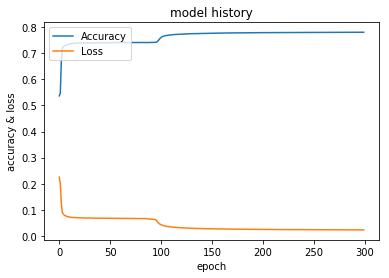

In [10]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['loss'])
plt.title('model history')
plt.ylabel('accuracy & loss')
plt.xlabel('epoch')
plt.legend(['Accuracy', 'Loss'], loc='upper left')
plt.show()

In [32]:
model1=Sequential()
model1.add(Conv3D(filters=256,kernel_size=(11,11,1),strides=(4,4,1),padding='valid',input_shape=(227,227,10,1),activation='tanh'))
model1.add(Conv3D(filters=128,kernel_size=(7,7,1),strides=(2,2,1),padding='valid',activation='tanh'))
model1.add(Conv3D(filters=64,kernel_size=(5,5,1),strides=(2,2,1),padding='valid',activation='tanh'))



model1.add(ConvLSTM2D(filters=64,kernel_size=(3,3),strides=1,padding='same',dropout=0.4,recurrent_dropout=0.3,return_sequences=True))


model1.add(ConvLSTM2D(filters=32,kernel_size=(3,3),strides=1,padding='same',dropout=0.3,return_sequences=True))



model1.add(ConvLSTM2D(filters=64,kernel_size=(3,3),strides=1,return_sequences=True, padding='same',dropout=0.5))



model1.add(Conv3DTranspose(filters=128,kernel_size=(5,5,1),strides=(2,2,1),padding='valid',activation='tanh'))
model1.add(Conv3DTranspose(filters=256,kernel_size=(7,7,1),strides=(2,2,1),padding='valid',activation='tanh'))
model1.add(Conv3DTranspose(filters=1,kernel_size=(11,11,1),strides=(4,4,1),padding='valid',activation='tanh'))

print(model1.summary())
model1.compile(optimizer='adam',loss='mean_squared_error',metrics=['accuracy'])
history1 = model1.fit(X_train,Y_train,batch_size=batch_size,epochs=125)
model1.save('model1.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_57 (Conv3D)           (None, 55, 55, 10, 256)   31232     
_________________________________________________________________
conv3d_58 (Conv3D)           (None, 25, 25, 10, 128)   1605760   
_________________________________________________________________
conv3d_59 (Conv3D)           (None, 11, 11, 10, 64)    204864    
_________________________________________________________________
conv_lst_m2d_58 (ConvLSTM2D) (None, 11, 11, 10, 64)    295168    
_________________________________________________________________
conv_lst_m2d_59 (ConvLSTM2D) (None, 11, 11, 10, 32)    110720    
_________________________________________________________________
conv_lst_m2d_60 (ConvLSTM2D) (None, 11, 11, 10, 64)    221440    
_________________________________________________________________
conv3d_transpose_57 (Conv3DT (None, 25, 25, 10, 128)   204928    
__________

167/167 [==============================] - 9s 54ms/step - loss: 0.0734 - acc: 0.7318
Epoch 70/125
167/167 [==============================] - 9s 56ms/step - loss: 0.0739 - acc: 0.7313
Epoch 71/125
167/167 [==============================] - 9s 54ms/step - loss: 0.0731 - acc: 0.7321
Epoch 72/125
167/167 [==============================] - 9s 55ms/step - loss: 0.0763 - acc: 0.7283
Epoch 73/125
167/167 [==============================] - 9s 53ms/step - loss: 0.0738 - acc: 0.7313
Epoch 74/125
167/167 [==============================] - 9s 54ms/step - loss: 0.0737 - acc: 0.7315
Epoch 75/125
167/167 [==============================] - 9s 55ms/step - loss: 0.0748 - acc: 0.7302
Epoch 76/125
167/167 [==============================] - 9s 54ms/step - loss: 0.0750 - acc: 0.7298
Epoch 77/125
167/167 [==============================] - 9s 54ms/step - loss: 0.0736 - acc: 0.7316
Epoch 78/125
167/167 [==============================] - 9s 54ms/step - loss: 0.0744 - acc: 0.7308
Epoch 79/125
167/167 [===========

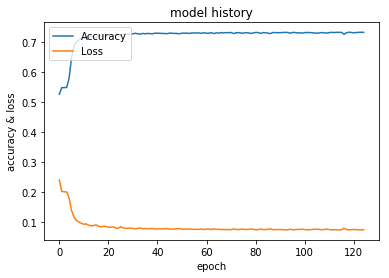

In [33]:
plt.plot(history1.history['acc'])
plt.plot(history1.history['loss'])
plt.title('model history')
plt.ylabel('accuracy & loss')
plt.xlabel('epoch')
plt.legend(['Accuracy', 'Loss'], loc='upper left')
plt.show()

In [34]:
from keras.layers import BatchNormalization
model2=Sequential()
model2.add(Conv3D(filters=128,kernel_size=(11,11,1),strides=(4,4,1),padding='valid',input_shape=(227,227,10,1),activation='tanh'))
model2.add(BatchNormalization())
model2.add(Conv3D(filters=64,kernel_size=(5,5,1),strides=(2,2,1),padding='valid',activation='tanh'))
model2.add(BatchNormalization())


model2.add(ConvLSTM2D(filters=64,kernel_size=(3,3),strides=1,padding='same',dropout=0.4,recurrent_dropout=0.3,return_sequences=True))


model2.add(ConvLSTM2D(filters=32,kernel_size=(3,3),strides=1,padding='same',dropout=0.3,return_sequences=True))


model2.add(ConvLSTM2D(filters=64,kernel_size=(3,3),strides=1,return_sequences=True, padding='same',dropout=0.5))


model2.add(BatchNormalization())
model2.add(Conv3DTranspose(filters=128,kernel_size=(5,5,1),strides=(2,2,1),padding='valid',activation='tanh'))
model2.add(BatchNormalization())
model2.add(Conv3DTranspose(filters=1,kernel_size=(11,11,1),strides=(4,4,1),padding='valid',activation='tanh'))

model2.compile(optimizer='adam',loss='mean_squared_error',metrics=['accuracy'])
print(model1.summary())
history2 = model2.fit(X_train,Y_train,batch_size=batch_size,epochs=125)
model2.save('model2.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_57 (Conv3D)           (None, 55, 55, 10, 256)   31232     
_________________________________________________________________
conv3d_58 (Conv3D)           (None, 25, 25, 10, 128)   1605760   
_________________________________________________________________
conv3d_59 (Conv3D)           (None, 11, 11, 10, 64)    204864    
_________________________________________________________________
conv_lst_m2d_58 (ConvLSTM2D) (None, 11, 11, 10, 64)    295168    
_________________________________________________________________
conv_lst_m2d_59 (ConvLSTM2D) (None, 11, 11, 10, 32)    110720    
_________________________________________________________________
conv_lst_m2d_60 (ConvLSTM2D) (None, 11, 11, 10, 64)    221440    
_________________________________________________________________
conv3d_transpose_57 (Conv3DT (None, 25, 25, 10, 128)   204928    
__________

In [35]:
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_60 (Conv3D)           (None, 55, 55, 10, 128)   15616     
_________________________________________________________________
batch_normalization_1 (Batch (None, 55, 55, 10, 128)   512       
_________________________________________________________________
conv3d_61 (Conv3D)           (None, 26, 26, 10, 64)    204864    
_________________________________________________________________
batch_normalization_2 (Batch (None, 26, 26, 10, 64)    256       
_________________________________________________________________
conv_lst_m2d_61 (ConvLSTM2D) (None, 26, 26, 10, 64)    295168    
_________________________________________________________________
conv_lst_m2d_62 (ConvLSTM2D) (None, 26, 26, 10, 32)    110720    
_________________________________________________________________
conv_lst_m2d_63 (ConvLSTM2D) (None, 26, 26, 10, 64)    221440    
__________

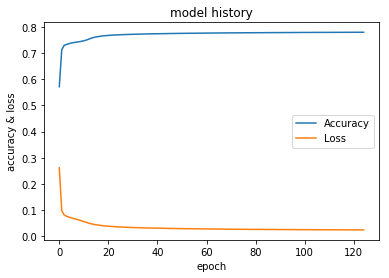

In [37]:
plt.plot(history2.history['acc'])
plt.plot(history2.history['loss'])
plt.title('model history')
plt.ylabel('accuracy & loss')
plt.xlabel('epoch')
plt.legend(['Accuracy', 'Loss'], loc='best')
plt.show()

In [38]:
from keras.layers import PReLU
model3=Sequential()
model3.add(Conv3D(filters=128,kernel_size=(11,11,1),strides=(4,4,1),padding='valid',input_shape=(227,227,10,1)))
model3.add(PReLU())
model3.add(BatchNormalization())
model3.add(Conv3D(filters=64,kernel_size=(5,5,1),strides=(2,2,1),padding='valid'))
model3.add(PReLU())
model3.add(BatchNormalization())


model3.add(ConvLSTM2D(filters=64,kernel_size=(3,3),strides=1,padding='same',dropout=0.4,recurrent_dropout=0.3,return_sequences=True))


model3.add(ConvLSTM2D(filters=32,kernel_size=(3,3),strides=1,padding='same',dropout=0.3,return_sequences=True))


model3.add(ConvLSTM2D(filters=64,kernel_size=(3,3),strides=1,return_sequences=True, padding='same',dropout=0.5))


model3.add(BatchNormalization())
model3.add(PReLU())
model3.add(Conv3DTranspose(filters=128,kernel_size=(5,5,1),strides=(2,2,1),padding='valid'))
model3.add(BatchNormalization())
model3.add(PReLU())
model3.add(Conv3DTranspose(filters=1,kernel_size=(11,11,1),strides=(4,4,1),padding='valid'))

model3.compile(optimizer='adam',loss='mean_squared_error',metrics=['accuracy'])
print(model3.summary())
history2 = model3.fit(X_train,Y_train,batch_size=batch_size,epochs=125)
model3.save('model3.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_62 (Conv3D)           (None, 55, 55, 10, 128)   15616     
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 55, 55, 10, 128)   3872000   
_________________________________________________________________
batch_normalization_5 (Batch (None, 55, 55, 10, 128)   512       
_________________________________________________________________
conv3d_63 (Conv3D)           (None, 26, 26, 10, 64)    204864    
_________________________________________________________________
p_re_lu_2 (PReLU)            (None, 26, 26, 10, 64)    432640    
_________________________________________________________________
batch_normalization_6 (Batch (None, 26, 26, 10, 64)    256       
_________________________________________________________________
conv_lst_m2d_64 (ConvLSTM2D) (None, 26, 26, 10, 64)    295168    
__________

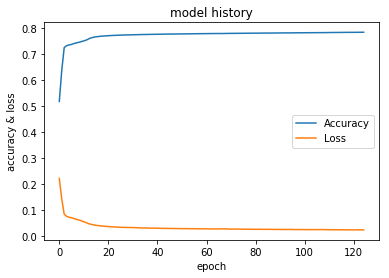

In [40]:
plt.plot(history2.history['acc'])
plt.plot(history2.history['loss'])
plt.title('model history')
plt.ylabel('accuracy & loss')
plt.xlabel('epoch')
plt.legend(['Accuracy', 'Loss'], loc='best')
plt.show()

In [42]:
from keras import regularizers
rglrzr = regularizers.l2(0.005)
model4=Sequential()
model4.add(Conv3D(filters=128,kernel_size=(11,11,1),strides=(4,4,1),padding='valid',kernel_regularizer=rglrzr,input_shape=(227,227,10,1)))
model4.add(PReLU())
model4.add(BatchNormalization())
model4.add(Conv3D(filters=64,kernel_size=(5,5,1),strides=(2,2,1),padding='valid',kernel_regularizer=rglrzr))
model4.add(PReLU())
model4.add(BatchNormalization())


model4.add(ConvLSTM2D(filters=64,kernel_size=(3,3),strides=1,padding='same',dropout=0.4,recurrent_dropout=0.3,return_sequences=True))


model4.add(ConvLSTM2D(filters=32,kernel_size=(3,3),strides=1,padding='same',dropout=0.3,return_sequences=True))


model4.add(ConvLSTM2D(filters=64,kernel_size=(3,3),strides=1,return_sequences=True, padding='same',dropout=0.5))


model4.add(BatchNormalization())
model4.add(PReLU())
model4.add(Conv3DTranspose(filters=128,kernel_size=(5,5,1),strides=(2,2,1),padding='valid',kernel_regularizer=rglrzr))
model4.add(BatchNormalization())
model4.add(PReLU())
model4.add(Conv3DTranspose(filters=1,kernel_size=(11,11,1),strides=(4,4,1),padding='valid',kernel_regularizer=rglrzr))

model4.compile(optimizer='adam',loss='mean_squared_error',metrics=['accuracy'])
print(model4.summary())
history4 = model4.fit(X_train,Y_train,batch_size=batch_size,epochs=125)
model4.save('model4.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_64 (Conv3D)           (None, 55, 55, 10, 128)   15616     
_________________________________________________________________
p_re_lu_5 (PReLU)            (None, 55, 55, 10, 128)   3872000   
_________________________________________________________________
batch_normalization_9 (Batch (None, 55, 55, 10, 128)   512       
_________________________________________________________________
conv3d_65 (Conv3D)           (None, 26, 26, 10, 64)    204864    
_________________________________________________________________
p_re_lu_6 (PReLU)            (None, 26, 26, 10, 64)    432640    
_________________________________________________________________
batch_normalization_10 (Batc (None, 26, 26, 10, 64)    256       
_________________________________________________________________
conv_lst_m2d_67 (ConvLSTM2D) (None, 26, 26, 10, 64)    295168    
__________

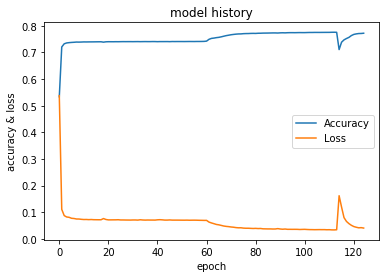

In [43]:
plt.plot(history4.history['acc'])
plt.plot(history4.history['loss'])
plt.title('model history')
plt.ylabel('accuracy & loss')
plt.xlabel('epoch')
plt.legend(['Accuracy', 'Loss'], loc='best')
plt.show()

In [46]:
model5=Sequential()
model5.add(Conv3D(filters=256,kernel_size=(5,5,1),strides=(3,3,1),padding='valid',input_shape=(227,227,10,1)))
model5.add(PReLU())
model5.add(BatchNormalization())
model5.add(Conv3D(filters=128,kernel_size=(5,5,1),strides=(2,2,1),padding='valid'))
model5.add(PReLU())
model5.add(BatchNormalization())


model5.add(ConvLSTM2D(filters=128,kernel_size=(3,3),strides=1,padding='same',dropout=0.4,recurrent_dropout=0.3,return_sequences=True))


model5.add(ConvLSTM2D(filters=64,kernel_size=(3,3),strides=1,padding='same',dropout=0.3,return_sequences=True))


model5.add(ConvLSTM2D(filters=128,kernel_size=(3,3),strides=1,return_sequences=True, padding='same',dropout=0.5))


model5.add(BatchNormalization())
model5.add(PReLU())
model5.add(Conv3DTranspose(filters=256,kernel_size=(5,5,1),strides=(2,2,1),padding='valid'))
model5.add(BatchNormalization())
model5.add(PReLU())
model5.add(Conv3DTranspose(filters=1,kernel_size=(5,5,1),strides=(3,3,1),padding='valid'))

model5.compile(optimizer='adam',loss='mean_squared_error',metrics=['accuracy'])
print(model5.summary())
history5 = model5.fit(X_train,Y_train,batch_size=batch_size,epochs=125)
model5.save('model5.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_70 (Conv3D)           (None, 75, 75, 10, 256)   6656      
_________________________________________________________________
p_re_lu_17 (PReLU)           (None, 75, 75, 10, 256)   14400000  
_________________________________________________________________
batch_normalization_21 (Batc (None, 75, 75, 10, 256)   1024      
_________________________________________________________________
conv3d_71 (Conv3D)           (None, 36, 36, 10, 128)   819328    
_________________________________________________________________
p_re_lu_18 (PReLU)           (None, 36, 36, 10, 128)   1658880   
_________________________________________________________________
batch_normalization_22 (Batc (None, 36, 36, 10, 128)   512       
_________________________________________________________________
conv_lst_m2d_76 (ConvLSTM2D) (None, 36, 36, 10, 128)   1180160   
__________

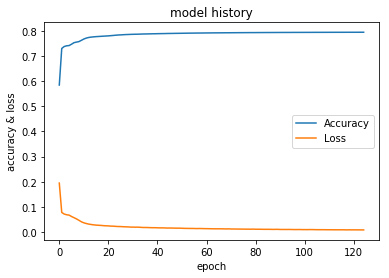

In [47]:
plt.plot(history5.history['acc'])
plt.plot(history5.history['loss'])
plt.title('model history')
plt.ylabel('accuracy & loss')
plt.xlabel('epoch')
plt.legend(['Accuracy', 'Loss'], loc='best')
plt.show()

In [76]:
newx=np.load('training_new.npy')
frames=newx.shape[2]
#Need to make number of frames divisible by 10


frames=frames-frames%10

# newx=newx[:,:,:frames]
# print(newx.shape)
# newx=newx.reshape(-1,227,227,10)
# print(newx.shape)
# newx=np.expand_dims(newx,axis=4)
# print(newx.shape)
# newy=newx.copy()


epochs=300
# epochs=args.n_epochs
batch_size=5

In [18]:
import tensorflow as tf
import keras
from keras.preprocessing.image import img_to_array,load_img
from sklearn.preprocessing import StandardScaler
import numpy as np 
import os 
from scipy.misc import imresize 
import argparse

# parser=argparse.ArgumentParser(description='Source Video path')
# parser.add_argument('source_vid_path',type=str)
# parser.add_argument('fps',type=int)
# args=parser.parse_args()

# video_source_path= args.source_vid_path

video_source_path= os.getcwd()+'/data/AvenueDataset/training_videos/'
fps=2
imagestore=[]
def store(image_path):
    img=load_img(image_path)
    img=img_to_array(img)
    #Resize the Image to (227,227,3) for the model to be able to process it. 
    img=imresize(img,(227,227,3))
    #Convert the Image to Grayscale
    gray=0.2989*img[:,:,0]+0.5870*img[:,:,1]+0.1140*img[:,:,2]
    imagestore.append(gray)



#List of all Videos in the Source Directory.
videos=os.listdir(video_source_path)
#Make a temp dir to store all the frames
if not os.path.isdir(video_source_path+'/frames'):
    os.mkdir(video_source_path+'/frames')
framepath=video_source_path+'/frames'
for video in videos:
    if not video == 'frames':
        os.system( 'ffmpeg -i {}/{} -r {}  {}/frames/%04d.jpg'.format(video_source_path,video,fps,video_source_path))
        images=os.listdir(framepath)
        for image in images:
            image_path=framepath+ '/'+ image
            store(image_path)


imagestore=np.array(imagestore)
a,b,c=imagestore.shape
#Reshape to (227,227,batch_size)
print(imagestore.shape)
imagestore.resize(b,c,a)
print(imagestore.shape)
#Normalize
imagestore=(imagestore-imagestore.mean())/(imagestore.std())
#Clip negative Values
# imagestore=np.clip(imagestore,0,1)
np.save('training_new.npy',imagestore)
#Remove Buffer Directory
os.system('rm -r {}'.format(framepath))


/home/kirtishukla261993/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


(1676, 227, 227)
(227, 227, 1676)


0

In [16]:
newx.mean()

0.36738947047912063

In [17]:
newx.std()

0.44502751424241754

In [20]:
newx.mean()

-2.2564926690661858e-06

In [21]:
newx.std()

1.0000033441154914

In [35]:
(np.min(newx,axis=4)).shape

(167, 227, 227, 10)

In [54]:
X = np.array([
    [ 0,  1],
    [ 2,  3],
    [ 4,  5],
    [ 6,  7],
    [ 8,  9],
    [10, 11],
    [12, 13],
    [14, 15]
])
X=np.expand_dims(X,axis=2)
np.min(X,axis=1)

array([[ 0],
       [ 2],
       [ 4],
       [ 6],
       [ 8],
       [10],
       [12],
       [14]])

In [55]:
np.max(X,axis=1)

array([[ 1],
       [ 3],
       [ 5],
       [ 7],
       [ 9],
       [11],
       [13],
       [15]])

In [52]:
X.shape

(8, 2, 1)

In [137]:
a = np.array([[[0,1,2],[3,4,5],[6,7,8]],[[9,10,11],[12,13,14],[15,16,17]],[[18,19,20],[21,22,23],[24,25,26]],[[27,28,29],[30,31,32],[33,34,35]]])
a[0]

array([[0, 1, 2],
       [3, 4, 5],
       [6, 7, 8]])

In [135]:
print(a[0].mean())
print(a[0].std())
print(np.max(a,axis=0))

4.0
2.581988897471611
[[27 28 29]
 [30 31 32]
 [33 34 35]]


In [136]:
from sklearn.preprocessing import MinMaxScaler
newa = (a[0]-a[0].mean())/a[0].std()
mms = MinMaxScaler()
newb = mms.fit_transform(newa)
print(newa)
print(newb)

[[-1.54919334 -1.161895   -0.77459667]
 [-0.38729833  0.          0.38729833]
 [ 0.77459667  1.161895    1.54919334]]
[[0.  0.  0. ]
 [0.5 0.5 0.5]
 [1.  1.  1. ]]


In [138]:
a=(a-a.mean())/(a.std())
a

array([[[-1.68458833, -1.58832614, -1.49206395],
        [-1.39580176, -1.29953957, -1.20327738],
        [-1.10701519, -1.010753  , -0.91449081]],

       [[-0.81822862, -0.72196643, -0.62570424],
        [-0.52944205, -0.43317986, -0.33691767],
        [-0.24065548, -0.14439329, -0.0481311 ]],

       [[ 0.0481311 ,  0.14439329,  0.24065548],
        [ 0.33691767,  0.43317986,  0.52944205],
        [ 0.62570424,  0.72196643,  0.81822862]],

       [[ 0.91449081,  1.010753  ,  1.10701519],
        [ 1.20327738,  1.29953957,  1.39580176],
        [ 1.49206395,  1.58832614,  1.68458833]]])

In [139]:
np.max(a)

1.6845883288916133

In [101]:
a = np.clip(a,0,1)
a

array([[[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.0481311 , 0.14439329, 0.24065548],
        [0.33691767, 0.43317986, 0.52944205],
        [0.62570424, 0.72196643, 0.81822862]],

       [[0.91449081, 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ]]])

In [105]:
a.resize(3,3,4)
a

array([[[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11]],

       [[12, 13, 14, 15],
        [16, 17, 18, 19],
        [20, 21, 22, 23]],

       [[24, 25, 26, 27],
        [28, 29, 30, 31],
        [32, 33, 34, 35]]])

In [106]:
print(a.mean())
print(a.std())
print(a.sum())

17.5
10.388294694831615
630


In [107]:
a=(a-a.mean())/(a.std())
a

array([[[-1.68458833, -1.58832614, -1.49206395, -1.39580176],
        [-1.29953957, -1.20327738, -1.10701519, -1.010753  ],
        [-0.91449081, -0.81822862, -0.72196643, -0.62570424]],

       [[-0.52944205, -0.43317986, -0.33691767, -0.24065548],
        [-0.14439329, -0.0481311 ,  0.0481311 ,  0.14439329],
        [ 0.24065548,  0.33691767,  0.43317986,  0.52944205]],

       [[ 0.62570424,  0.72196643,  0.81822862,  0.91449081],
        [ 1.010753  ,  1.10701519,  1.20327738,  1.29953957],
        [ 1.39580176,  1.49206395,  1.58832614,  1.68458833]]])

In [108]:
a = np.clip(a,0,1)
a

array([[[0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ]],

       [[0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.0481311 , 0.14439329],
        [0.24065548, 0.33691767, 0.43317986, 0.52944205]],

       [[0.62570424, 0.72196643, 0.81822862, 0.91449081],
        [1.        , 1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        , 1.        ]]])

In [80]:
newxr = newx.reshape(-1,227,227)
newxr.shape

(1676, 227, 227)

In [79]:
newx[0][0]

array([-0.88524775, -0.88524775, -0.88524775, ..., -0.43378282,
       -0.38578412, -0.33778541])

In [82]:
newxr[0][0]

array([-0.88524775, -0.88524775, -0.88524775, -0.85324862, -0.85324862,
       -0.82881804, -0.77534694, -0.77534694, -0.77534694, -0.75934737,
       -0.75934737, -0.70464098, -0.65602463, -0.06012036,  1.36593728,
        2.00801612,  2.01193641,  1.81126577,  1.69266191,  1.54866581,
        1.24780546,  0.9165973 ,  0.56825509,  0.20078188, -0.08060345,
       -0.33659653, -0.51259177, -0.62458874, -0.70643791, -0.72879954,
       -0.72879954, -0.79279781, -0.80401463, -0.79575642, -0.72752105,
       -0.71926284, -0.71926284, -0.70326328, -0.70326328, -0.70326328,
       -0.69091198, -0.69091198, -0.37092063,  0.18906422,  0.70105037,
        1.54920025,  1.36859507, -0.10336511, -0.7433478 , -0.72734823,
       -0.71134867, -0.7433478 , -0.71134867,  0.08862969,  0.80861022,
        0.29662407,  0.45018567,  1.37103685,  1.53103252,  0.8590507 ,
        0.34706455, -0.03692506, -0.24474663, -0.21918156, -0.19657511,
       -0.26535613, -0.29735526, -0.30213801, -0.29969783, -0.29